250000000.0 1048576

 Charge Distribution ;  No of Events 28689


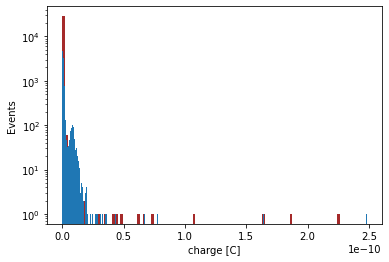

In [1]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

res = 50
mins = []
locs = []
charge  = [] 
time = []
charge1 = [] 
coulombArr = []
locV = 0
first_element1 = []
overflow_location1 = []
first_element = []
overflow_location = []
newArr = []
tot_charge = 0
Max_charge = 0
charge_average = 0

# Function to read in digitizer properties
def readDigitizer(r):
    child = r.find('digitizer')
    frequency = child.find('frequency').get('hz')
    samples = child.find('maxsamples').get('maxsamples')
    
    return frequency, samples

# Function to read in events
def readEvents(r,freq):

    for a in r.findall('event/trace'):
        testArr = [] # array to hold the voltages of the wave
        st = a.text # read in the voltages
        testArr = [float(b) for b in st.split()] # convert text to float
        mean = sum(testArr)/len(testArr) # mean (claculating the baseline)
        newArr = [(b  - mean) for b in testArr] # array with baseline correction (centered around 0)
        coulombArr = [((float(c)*(10.0**-3)/(res*float(freq)))) for c in newArr] # convert mV array into pC (voltage to charge) (HINT: frequency will give you the time in the bin)
        charge_average = sum(coulombArr)/len(coulombArr)
        for i in range(0,len(newArr)) :
            if (newArr[i] > 100 ):
                first_element.append(newArr[i] * (10.0**-3)/(res*float(freq)))
                #first_element.append(coulombArr[i])
                overflow_location.append(i * 1/float(freq))   
                
        for i in range(0,len(coulombArr)) :
            if (coulombArr[i] > charge_average ):
                #first_element1.append(newArr[i] * (10.0**-3)/(res*float(freq)))
                first_element1.append(coulombArr[i])
                overflow_location1.append(i * 1/float(freq))    
           
        minV,locV,Q = findpeak(coulombArr)
        #put if code , save it to png , limit the number of plots to save individual waves 
        mins.append(minV*(-1))
        charge.append(minV )
        locs.append(locV * 1/ float(freq))
        time.append(locV * 1/float(freq))
        charge1.append(float(Q) * (-1)) #     
    
    #print("No of Events",len(time))
    
    # Distribution of charge
    print("\n Charge Distribution ; ", "No of Events",len(time))
    hist,bins,_ = plt.hist(mins,100,color = "brown",lw = 0)
    plt.hist(charge1,bins = 1000)
    plt.yscale('log')
    plt.xlabel ("charge [C]")
    plt.ylabel("Events")
    plt.show()
    
def findpeak(r): # make function to find minimum in array (findpeak)
    min_value = float(r[0])
    loc_value = 0
    total_charge = 0
    
 #findpeak    

    for i in range (0,len(r)):
        if (min_value > r[i]):
            min_value = r[i]
            loc_value = i
            
#integration code   

    for i in range(loc_value, len(r)):      
        if (r[i] < 0):    
            total_charge += float(r[i])
        else:
            break    
    for i in range(1, loc_value):
        if (r[loc_value - i] < 0):
            total_charge += float(r[loc_value - i])  
        else:
            break      
        
    return(min_value,loc_value,total_charge)    

def main():
    tree = ET.parse('220330_1.xml')
    root = tree.getroot()
    frequency, samples = readDigitizer(root)
    print(frequency,samples)
    readEvents(root,frequency)
    
if __name__ == "__main__":
    main()

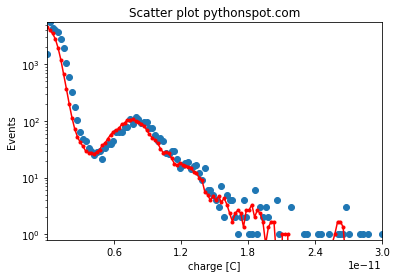

In [82]:
import math

maxch = 0
binno = 1000

for i in range(len(charge1)):
    if charge1[i] > maxch:
        maxch = charge1[i]

binwidth = maxch/binno
binheights = []
binpos = []

for i in range(binno):
    specheight = 0
    for a in range(len(charge1)):
        if charge1[a] > (binwidth*i) and charge1[a] < binwidth*(i+1):
            specheight = specheight + 1
    binheights.append(specheight)
    binpos.append(binwidth*i)
    
maxhe = 0
minhe = 1*10**(-0.1)
for i in range(len(binheights)):
    if binheights[i] > maxhe:
        maxhe = binheights[i]
for i in range(len(binheights)):
    if binheights[i] < minhe and binheights[i] > 0:
        minhe = binheights[i]
        
threepa = []
for i in range(len(binheights)):
    if i > 1 and i < len(binheights)-1:
        threepa.append((binheights[i-1] + binheights[i] + binheights[i+1]) / 3)
extra = len(binheights) - len(threepa)
for i in range(extra):
    threepa.append(0)
    
y = binheights
x = binpos
specscale = 3e-11
plt.scatter(x, y)
plt.title('Scatter plot pythonspot.com')
plt.yscale('log')
plt.ylim(minhe, maxhe)
plt.xticks([specscale/5, specscale*2/5, specscale*3/5, specscale*4/5, specscale])
plt.xlim(0, specscale)
plt.xlabel ("charge [C]")
plt.ylabel("Events")
plt.plot(x, threepa, 'r.-', label='Running average')
plt.show()

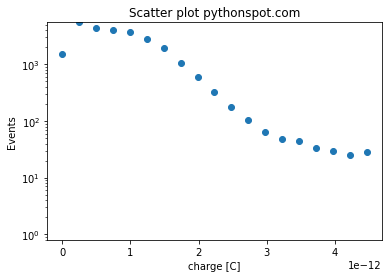

In [4]:
expoheights1 = []
expopos1 = []
expoheights2 = []
expopos2 = []
currentmin = binheights[0]
for i in range(len(binheights)-1):
    if binheights[i] > binheights[i+1] and binpos[i] < binpos[i+1] and binheights[i] < currentmin:
        expoheights1.append(binheights[i])
        expopos1.append(binpos[i])
        currentmin = binheights[i]
for i in range(len(expoheights1)-1):
    if expoheights1[i] > expoheights1[i+1] and expopos1[i] < expopos1[i+1]:
        expoheights2.append(binheights[i])
        expopos2.append(binpos[i])

y = expoheights2
x = expopos2        

plt.scatter(x, y)
plt.title('Scatter plot pythonspot.com')
plt.yscale('log')
plt.ylim(minhe, maxhe)
plt.xlabel ("charge [C]")
plt.ylabel("Events")
plt.show()

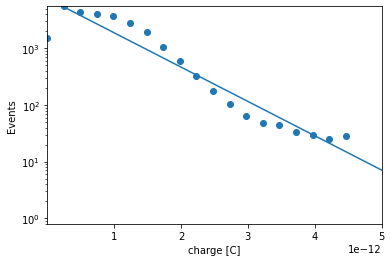

In [5]:
import math

y = expoheights2
x = expopos2

#fit the model
fit = np.polyfit(x, np.log(y), 1)

plt.scatter(x, y)
plt.yscale('log')
plt.xticks([1e-12, 2e-12, 3e-12, 4e-12, 5e-12])
plt.ylim(minhe, maxhe)
plt.xlim(0, 5e-12)
plt.xlabel ("charge [C]")
plt.ylabel("Events")

x = np.arange(0, maxch, binwidth)

plt.plot(x, (math.e)**(fit[1]+fit[0]*x))

plt.show()

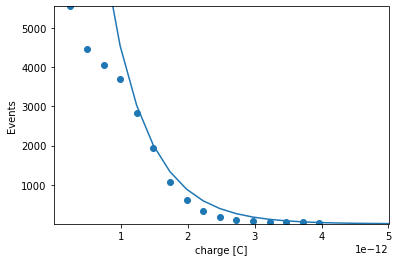

In [67]:
import math

maxch = 0
binno = 1000
specscale = 5e-12
cutparam = 1.7

for i in range(len(charge1)):
    if charge1[i] > maxch:
        maxch = charge1[i]

binwidth = maxch/binno
binheights = []
binpos = []

for i in range(binno):
    specheight = 0
    for a in range(len(charge1)):
        if charge1[a] > (binwidth*i) and charge1[a] < binwidth*(i+1):
            specheight = specheight + 1
    binheights.append(specheight)
    binpos.append(binwidth*i)
    
maxhe = 0
minhe = 1*10**(-0.1)
maxpos = 0
for i in range(len(binheights)):
    if binheights[i] > maxhe:
        maxhe = binheights[i]
        maxpos = i
for i in range(len(binheights)):
    if binheights[i] < minhe and binheights[i] > 0:
        minhe = binheights[i]

import math

expoheights1 = []
expopos1 = []

currentmin = maxhe
expoheights1.append(maxhe)
expopos1.append(maxpos*binwidth)

for i in range(len(binheights)-2):
    if binheights[i] > binheights[i+1] and binheights[i] > binheights[i+2] and binheights[i] < currentmin and i > maxpos:
        if binwidth*i < specscale:
            expoheights1.append(binheights[i])
            expopos1.append(binpos[i])
            currentmin = binheights[i]

y = expoheights1
x = expopos1

#fit the model
fit = np.polyfit(x, np.log(y), 1)

plt.scatter(x, y)
plt.xticks([specscale/5, specscale*2/5, specscale*3/5, specscale*4/5, specscale])
plt.ylim(minhe, maxhe)
plt.xlim(0, specscale)
plt.xlabel ("charge [C]")
plt.ylabel("Events")

x = np.arange(0, maxch, binwidth)

plt.plot(x, cutparam*(math.e)**(fit[1]+fit[0]*x))

plt.show()

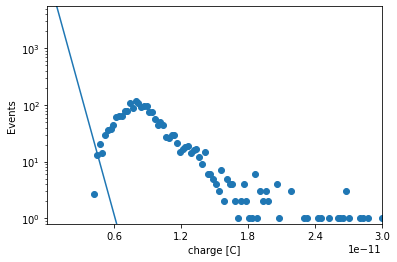

In [98]:
specscale = 3e-11
sansexpo = []
gausspos = []
for i in range(len(binheights)):
    if binheights[i]-(cutparam*(math.e)**(fit[1]+fit[0]*binpos[i])) > 0:
        sansexpo.append(binheights[i]-(cutparam*(math.e)**(fit[1]+fit[0]*binpos[i])))
        gausspos.append(binpos[i])

y = sansexpo
x = gausspos

plt.scatter(x, y)
plt.yscale('log')
plt.ylim(minhe, maxhe)
plt.xticks([specscale/5, specscale*2/5, specscale*3/5, specscale*4/5, specscale])
plt.xlim(0, specscale)
plt.xlabel ("charge [C]")
plt.ylabel("Events")
x = np.arange(0, maxch, binwidth)
plt.plot(x, cutparam*(math.e)**(fit[1]+fit[0]*x))
plt.show()

Mean = 9.614648467598742e-12 Sigma = 7.828664656782881e-12


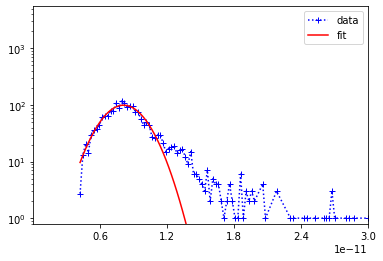

In [112]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

y = sansexpo
x = gausspos
z = []
# weighted arithmetic mean (corrected - check the section below)
for i in range(len(sansexpo)):
    z.append(y[i]*x[i])
mean = sum(z) / sum(y)
sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))

def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

popt,pcov = curve_fit(Gauss, x, y, p0=[max(y), mean, sigma])

plt.plot(x, y, 'b+:', label='data')
plt.plot(x, Gauss(x, *popt), 'r-', label='fit')
plt.yscale('log')
plt.ylim(minhe, maxhe)
plt.xticks([specscale/5, specscale*2/5, specscale*3/5, specscale*4/5, specscale])
plt.xlim(0, specscale)
print("Mean =", mean, "Sigma =", sigma)
plt.legend()
plt.show()